# Clasificador de reseñas

## Imports necesariosimport pandas as pd

In [1]:
import pandas as pd
import os
import torch
import numpy as np
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast, Trainer, TrainingArguments, RobertaConfig, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

/srv/home/tfg24_01/ibmalles/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Selecionar la mejor GPU

In [2]:
import os
import torch
import subprocess

def get_best_gpu():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader'],
                            stdout=subprocess.PIPE, text=True)
    free_mem = [int(x) for x in result.stdout.strip().split("\n")]
    best_gpu = free_mem.index(max(free_mem))
    return best_gpu

best_gpu = get_best_gpu()
os.environ["CUDA_VISIBLE_DEVICES"] = str(best_gpu)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando GPU: {torch.cuda.get_device_name(device)}")


Usando GPU: NVIDIA GeForce RTX 3080


## Importar los datos

### Funciones que se van a utilizar

Función para exportar un txt a un dataframe 

In [3]:
def importFromTxtToDF(source, label):
    with open(source, 'r', encoding="utf-8") as file:
        #Generate a list with all the reviews
        targetList = [line.strip() for line in file]

    targetDF = pd.DataFrame(targetList, columns=['review'])

    targetDF["label"] = label
    
    return targetDF

In [4]:
def dataToDataFrames(invalidReviewsPath, validReviewsPath):
    
    #Export data to dataframes
    invalidReviewsDF = importFromTxtToDF(invalidReviewsPath, "n") # n is the label of the invalid reviews
    validReviewsDF = importFromTxtToDF(validReviewsPath, "v") # v is the label of the valid reviews
    
    #Combine dataframes
    return pd.concat([invalidReviewsDF, validReviewsDF], ignore_index = True)

Función que divide el conjunto de datos en entrenamiento, validación y test. Además proporciona una lista de índices, correspondientes al conjunto de datos original, de los datos de test y validación

In [5]:
def trainTestValidationSplit(dataset, trainPctg = 0.8):

    #Add a column with the original index
    dataset = dataset.add_column("originalIdx", list(range(len(dataset))))

    #Divide the dataset
    datasetSplit = dataset.train_test_split(test_size = 1 - trainPctg, seed = 54)
    validationTestSplit = datasetSplit["test"].train_test_split(test_size = 0.5, seed = 54)

    #Generate the datasets
    trainDataset = datasetSplit["train"]
    validationDataset = validationTestSplit["train"]
    testDataset = validationTestSplit["test"]

    #Extract the list of indexes corresponding to the test and validation data
    testValidationIdx = validationDataset["originalIdx"] + testDataset["originalIdx"]

    #Dataset dictionary
    datasetDict = DatasetDict({
        "train" : trainDataset,
        "validation" : validationDataset,
        "test" : testDataset
        })

    #Remove the originalIdx column from all datasets in the dictionary
    datasetDict = datasetDict.map(lambda x: x, remove_columns = ["originalIdx"])

    #Shufle the datasets
    for split in datasetDict.keys():
        datasetDict[split] = datasetDict[split].shuffle()

    return datasetDict, testValidationIdx

### Datos originales

Con datos originales nos referimos a aquellos que no han sido generados usando técnicas de aumento de datos.

In [6]:
originalInvalidReviewsPath = "../1. Data/4. Labeled Reviews/2. Without Emojis/InvalidReviews.txt"
originalValidReviewsPath = "../1. Data/4. Labeled Reviews/2. Without Emojis/ValidReviews.txt"

originalDF = dataToDataFrames(originalInvalidReviewsPath, originalValidReviewsPath)

Se muestran los datos

In [7]:
originalDF.head()

,review,label
0,"""He vivido 35 años en el barrio y reconozco qu...",n
1,"""localización con muchos bares interesantes""",n
2,"""…""",n
3,"""Muy rica comida..""",n
4,"""Estación del.metro""",n


Número de elementos de cada clase

In [8]:
originalDF["label"].value_counts()

label
v    1943
n    1291
Name: count, dtype: int64

Para que las clases sean compatibles con el entrenamiento, se va a hacer que la columna label sea numérica: n = 0 y v = 1

In [9]:
originalDF['label'] = originalDF['label'].map({'v': 1, 'n': 0})

In [10]:
originalDF.head()

,review,label
0,"""He vivido 35 años en el barrio y reconozco qu...",0
1,"""localización con muchos bares interesantes""",0
2,"""…""",0
3,"""Muy rica comida..""",0
4,"""Estación del.metro""",0


Convertir el conjunto de datos en un dataset de HuggingFace

In [11]:
originalDataset = Dataset.from_pandas(originalDF)

print(originalDataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 3234
})


Dividir el conjunto de datos en entrenamiento, validación y test. Y extraer los índices de los datos en el conjunto de validación y test.

In [12]:
originalDataDict, testValidationIdx = trainTestValidationSplit(originalDataset)

print(originalDataDict)

Map: 100%|██████████| 324/324 [00:00<00:00, 9289.07 examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 2587
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 323
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 324
    })
})


Filas que no se deberán incluir en los conjuntos de datos sintéticos

In [13]:
testValidationIdx

[2016,
 3062,
 574,
 528,
 1425,
 2131,
 2954,
 1011,
 332,
 370,
 3133,
 1734,
 1541,
 405,
 1457,
 1780,
 1116,
 1943,
 7,
 647,
 2901,
 1371,
 1614,
 226,
 938,
 879,
 161,
 2455,
 1364,
 2924,
 2350,
 2091,
 1577,
 613,
 2432,
 1035,
 2569,
 414,
 2471,
 1178,
 2867,
 2547,
 84,
 1520,
 2107,
 1081,
 1760,
 2967,
 2909,
 54,
 814,
 2566,
 1084,
 1753,
 1472,
 1930,
 2435,
 1998,
 1409,
 591,
 1162,
 520,
 1227,
 630,
 2096,
 1028,
 618,
 436,
 74,
 1401,
 2508,
 3045,
 823,
 800,
 1817,
 2784,
 1608,
 2305,
 1346,
 2103,
 991,
 1745,
 2354,
 966,
 1308,
 2743,
 2261,
 190,
 3110,
 3195,
 768,
 1807,
 2014,
 2703,
 2864,
 1828,
 2704,
 20,
 2061,
 1684,
 1925,
 2218,
 2494,
 3042,
 2384,
 1626,
 1070,
 2021,
 2128,
 1176,
 1913,
 2739,
 1290,
 2980,
 2726,
 2208,
 2048,
 424,
 1637,
 837,
 2763,
 705,
 1330,
 915,
 1126,
 812,
 1154,
 1718,
 860,
 138,
 944,
 2306,
 2643,
 2918,
 2200,
 495,
 2854,
 3151,
 3014,
 305,
 2488,
 3091,
 1451,
 2034,
 1640,
 698,
 1517,
 2890,
 1672,
 17

### Datos sintéticos

Estos datos son aquellos que se han generado mediante las técnicas de aumento de datos

#### Retrotraducción

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [14]:
backtranslationInvalidReviewsPath = "1. Data Augmentation/1. Back Translation/3. Augmented Data/InvalidBackTranslationData.txt"
backtranslationValidReviewsPath = "1. Data Augmentation/1. Back Translation/3. Augmented Data/ValidBackTranslationData.txt"

#Import data
bactranslationDF = dataToDataFrames(backtranslationInvalidReviewsPath, backtranslationValidReviewsPath)

#Delete rows
bactranslationDF = bactranslationDF.drop(testValidationIdx)

Se muestran los datos

In [15]:
bactranslationDF.head()

,review,label
0,“Vivo en esta zona desde hace 35 años y recono...,n
1,"""Ubicación con muchos bares interesantes""",n
2,"""…""",n
3,"""Es una comida muy deliciosa"".",n
4,"""Estación de metro""",n


Número de elementos en cada clase

In [16]:
bactranslationDF["label"].value_counts()

label
v    1543
n    1044
Name: count, dtype: int64

#### Modelos de lenguaje preentreandos

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [17]:
pretrainedNLPInvalidReviewsPath = "1. Data Augmentation/2. Pretrained NLP/2. Augmented Data/InvalidGPT4oMiniData.txt"
pretrainedNLPValidReviewsPath = "1. Data Augmentation/2. Pretrained NLP/2. Augmented Data/ValidGPT4oMiniData.txt"

#Import data
pretrainedNLPDF = dataToDataFrames(pretrainedNLPInvalidReviewsPath, pretrainedNLPValidReviewsPath)

#Remove rows
pretrainedNLPDF = pretrainedNLPDF.drop(testValidationIdx)

Se muestran los datos

In [18]:
pretrainedNLPDF.head()

,review,label
0,"""""Después de haber pasado 35 años en este veci...",n
1,"""""zona con una gran cantidad de bares atractiv...",n
2,"""Parece que no has proporcionado un texto para...",n
3,"""""Deliciosa gastronomía.""""",n
4,"""""Terminal del tren subterráneo""""",n


Número de elementos en cada clase

In [19]:
pretrainedNLPDF["label"].value_counts()

label
v    1543
n    1044
Name: count, dtype: int64

#### Mixed EDA

Este conjunto de datos se ha construido usando las técnicas de: reemplazo por sinónimos, inserción aleatoria, eliminación aleatoria e intercambio aleatorio.

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [20]:
mixedEDAInvalidReviewsPath = "1. Data Augmentation/7. Mixed EDA/2. Augmented Data/InvalidMixedEDAData.txt"
mixedEDAValidReviewsPath = "1. Data Augmentation/7. Mixed EDA/2. Augmented Data/ValidMixedEDAData.txt"

#Import data
mixedEDADF = dataToDataFrames(mixedEDAInvalidReviewsPath, mixedEDAValidReviewsPath)

#Remove rows
mixedEDADF = mixedEDADF.drop(testValidationIdx)

Se muestran los datos

In [21]:
mixedEDADF.head()

,review,label
0,"""barrio desaparecido. 35 mucho tiempo en el pr...",n
1,"""localizacion bares con muchos ""localización""",n
2,"""…""",n
3,"""rica rica Muy""",n
4,"""Estación del.metro""",n


Número de elementos en cada clase

In [22]:
mixedEDADF["label"].value_counts()

label
v    1543
n    1044
Name: count, dtype: int64

#### Albumentación

Se importan los datos eliminando aquellas filas que se vayan a utilizar para entrear y validar en el conjunto original de datos

In [23]:
albumentationInvalidReviewsPath = "1. Data Augmentation/8. Albumentation/2. Augmented Data/InvalidAlbumentationData.txt"
albumentationValidReviewsPath = "1. Data Augmentation/8. Albumentation/2. Augmented Data/ValidAlbumentationData.txt"

#Import data
albumentationDF = dataToDataFrames(albumentationInvalidReviewsPath, albumentationValidReviewsPath)

#Remove rows
albumentationDF = albumentationDF.drop(testValidationIdx)

Se muestran los datos

In [24]:
albumentationDF.head()

,review,label
0,"""He vivido 35 años en el barrio y reconozco qu...",n
1,"""localización con muchos bares interesantes.""",n
2,"""….""",n
3,"""Muy rica comida.""",n
4,"""Estación del. metro.""",n


Número de elementos en cada clase

In [25]:
albumentationDF["label"].value_counts()

label
v    1543
n    1044
Name: count, dtype: int64

#### Combinación de todos los métodos (unión de los dataframes)

In [26]:
#Combine dataframes
syntheticDF = pd.concat([bactranslationDF, pretrainedNLPDF, mixedEDADF, albumentationDF], ignore_index = True)

#Shuffle the dataframe
syntheticDF = syntheticDF.sample(frac = 1).reset_index(drop = True)

Se muestran los datos

In [27]:
syntheticDF.head()

,review,label
0,"""Aún así me parece muy ineficaz. La parada más...",n
1,"""Buena estación de metrosur.""",v
2,"""….""",n
3,"""complacerse ""Bonita plaza donde deleitarse de...",n
4,"""¡Está demasiado lejos!""",n


Número de elementos de cada clase

In [28]:
syntheticDF["label"].value_counts()

label
v    6172
n    4176
Name: count, dtype: int64

Para que las clases sean compatibles con el entrenamiento, se va a hacer que la columna label sea numérica: n = 0 y v = 1

In [29]:
syntheticDF['label'] = syntheticDF['label'].map({'v': 1, 'n': 0})

In [30]:
syntheticDF.head()

,review,label
0,"""Aún así me parece muy ineficaz. La parada más...",0
1,"""Buena estación de metrosur.""",1
2,"""….""",0
3,"""complacerse ""Bonita plaza donde deleitarse de...",0
4,"""¡Está demasiado lejos!""",0


Como se puede ver, se ha multiplicado por 5 el número de datos disponibles para entrenar el clasificador

## Diseño y entrenamiento del clasificador de reseñas

Se va a realizar el entrenamiento en dos etapas: la primera etapa de preentrenamiento para adaptar al modelo al dominio y estilo de las reseñas, utilizando únicamente los datos sintéticos. Y una seguanda etapa, la de refinamiento, con los datos reales para qeu el modelo se adapte a la verdadera distribución y complejiad de las reseñas.



### Etapa 1

#### Elección del modelo

In [31]:
modelName = 'FacebookAI/xlm-roberta-base'
tokenizer = XLMRobertaTokenizerFast.from_pretrained(modelName)
model = XLMRobertaForSequenceClassification.from_pretrained(modelName, num_labels = 2, hidden_dropout_prob = 0.3, attention_probs_dropout_prob = 0.3)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Preparación de los datos

Convertir los datos a un dataset de HuggingFace

In [32]:
syntheticDataset = Dataset.from_pandas(syntheticDF)

print(syntheticDataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 10348
})


Función para tokenizar los textos

In [33]:
def tokenizeFunction(examples):
    return tokenizer(examples["review"], truncation=True, padding='max_length', max_length=512)

Tokenizar y preparar el dataset sintético

In [34]:
syntheticDataset = syntheticDataset.map(tokenizeFunction, batched = True)
syntheticDataset = syntheticDataset.shuffle(seed = 42)
syntheticDataset.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 10348/10348 [00:03<00:00, 2618.27 examples/s]


#### Configuración del entrenamiento

In [35]:
savingPath = "../../1. Models/Clasificador/TrainingSynthetic"


syntheticTrainingArgs = TrainingArguments(
    output_dir = savingPath,
    num_train_epochs = 12, 
    learning_rate = 5e-6,
    per_device_train_batch_size = 8,     
    per_device_eval_batch_size = 8,
    evaluation_strategy = "no", # no evaluation
    save_strategy = "epoch",
    logging_steps = 10,
    fp16 = True, # Activate mixed precision for the RTX 3060 
)

syntheticTrainer = Trainer(
    model = model,
    args = syntheticTrainingArgs,
    train_dataset = syntheticDataset,
)


/srv/home/tfg24_01/ibmalles/.pyenv/versions/3.13.1/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Entrenamiento con datos sintéticos

In [36]:
syntheticTrainer.train()

Step,Training Loss
10,0.691600
20,0.685700
30,0.671800
40,0.682000
50,0.674900
60,0.671400
70,0.713600
80,0.665100
90,0.662400
100,0.694100


TrainOutput(global_step=15528, training_loss=0.4756786607854579, metrics={'train_runtime': 2160.7236, 'train_samples_per_second': 57.47, 'train_steps_per_second': 7.186, 'total_flos': 3.267207841038336e+16, 'train_loss': 0.4756786607854579, 'epoch': 12.0})

Guardar el modelo

In [37]:
savingPath = "../../1. Models/Clasificador/ResultsSynthetic"

model.save_pretrained(savingPath)
tokenizer.save_pretrained(savingPath)

('../../1. Models/Clasificador/ResultsSynthetic/tokenizer_config.json',
 '../../1. Models/Clasificador/ResultsSynthetic/special_tokens_map.json',
 '../../1. Models/Clasificador/ResultsSynthetic/tokenizer.json')

### Etapa 2

#### Carga del modelo y el tokenizador de la etapa anterior

In [38]:
savingPath = "../../1. Models/Clasificador/ResultsSynthetic"
tokenizer = XLMRobertaTokenizerFast.from_pretrained(savingPath)
model = XLMRobertaForSequenceClassification.from_pretrained(savingPath, num_labels = 2)

#### Preparación de los datos

Función para tokenizar los textos

In [39]:
def tokenizeFunction(examples):
    return tokenizer(examples["review"], truncation=True, padding='max_length', max_length=512)

Tokenizar y preparar el dataset con datos originales

In [40]:
originalDataDict = originalDataDict.map(tokenizeFunction, batched = True)
originalDataDict.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 324/324 [00:00<00:00, 5532.08 examples/s]


#### Configuración del entrenamiento

Función de métricas

In [41]:
def computeMetrics(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Función para parar el entrenamiento cuando hay varias épocas en las que le validation loss empeora

In [42]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("⏹️ Early Stopping activado.")
                return True  # Stop the training
        return False # Continue the training

In [43]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Número de épocas sin mejora para detener el entrenamiento
    early_stopping_threshold=0.01,  # Umbral mínimo de mejora en la métrica (eval_loss) para considerar que ha mejorado
)

In [44]:
savingPath = "../../1. Models/Clasificador/TrainingOriginalData"

originalDatatrainingArgs = TrainingArguments(
    output_dir = savingPath,
    num_train_epochs = 20,
    learning_rate = 5e-6,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
)

originalDataTrainer = Trainer(
    model = model,
    args = originalDatatrainingArgs,
    train_dataset = originalDataDict['train'],
    eval_dataset = originalDataDict['validation'],
    compute_metrics = computeMetrics, 
    callbacks = [early_stopping_callback]
)

#### Ajuste del modelo con datos originales

In [45]:
originalDataTrainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.705982,0.804954,0.798787,0.782440,0.788536
2,0.373100,0.735047,0.811146,0.804628,0.790505,0.796004
3,0.373100,0.733368,0.814241,0.806619,0.796057,0.800420
4,0.380800,0.774661,0.811146,0.808257,0.785946,0.793671


TrainOutput(global_step=1296, training_loss=0.3732202141373246, metrics={'train_runtime': 195.1881, 'train_samples_per_second': 265.078, 'train_steps_per_second': 33.199, 'total_flos': 2722673200865280.0, 'train_loss': 0.3732202141373246, 'epoch': 4.0})

#### Guardar el clasificador

In [46]:
savingPath = "../../1. Models/Clasificador/ResultsOriginalData"

model.save_pretrained(savingPath)
tokenizer.save_pretrained(savingPath)

('../../1. Models/Clasificador/ResultsOriginalData/tokenizer_config.json',
 '../../1. Models/Clasificador/ResultsOriginalData/special_tokens_map.json',
 '../../1. Models/Clasificador/ResultsOriginalData/tokenizer.json')

#### Evaluación del modelo sobre el conjunto de test

Classification Report:

              precision    recall  f1-score   support

    inválida       0.82      0.74      0.78       123
      válida       0.85      0.90      0.87       201

    accuracy                           0.84       324
   macro avg       0.83      0.82      0.83       324
weighted avg       0.84      0.84      0.84       324



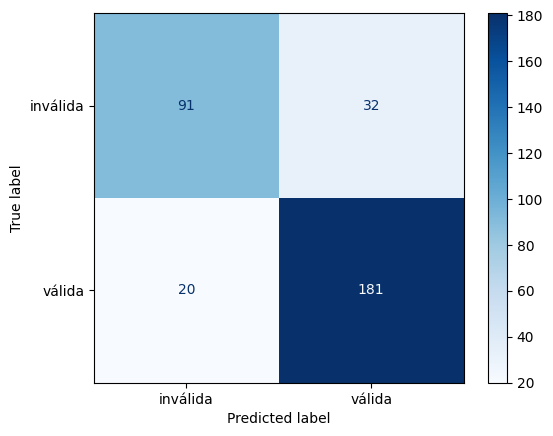

In [47]:
# Obtain predictions
predictions = originalDataTrainer.predict(originalDataDict["test"])

#Extract logits and calculate final predictions
logits = predictions.predictions
yPred = np.argmax(logits, axis = 1)
yTrue = predictions.label_ids

#Print the clasification metrics
print("Classification Report:\n")
print(classification_report(yTrue, yPred, target_names = ['inválida', 'válida']))

#Confusion matrix
cm = confusion_matrix(yTrue, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['inválida', 'válida'])
disp.plot(cmap = "Blues")